In [1]:
%load_ext autoreload

In [2]:
%autoreload 2

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import time
import numpy as np
import datetime
import gc

In [4]:
# sns.set(style="white")
plt.style.use("dark_background")

In [5]:
from utils import sql_table_to_pandas, str2iter_match_ratio
from plotting import (
    plot_countplot,
    plot_aggregated_barplot,
    plot_lineplot,
    plot_normalised_barplot,
    plot_distplot
)

In [6]:
pd.set_option(
    'display.max_rows', 100,
    'display.max_columns', None,
    'display.max_colwidth', 200,
    'display.width', 100,
    'display.float_format', '{:4,.2f}'.format
)


## Dataset description

- *status*: investigation status
- *time*: the time of accident
- *day*: the day of accident
- *month*: the monthe of accident
- *year*: the year of accdient
- *first_flight*: the year of aircraft first flight
- *total_airframe_hrs*: the hours that aircraft flied
- *aircraft_type*: the model of aircraft
- *operator*: the company, organisation or individual operating the aircraft at the time of the accident
- *country*: the country of accident
- *location*: more detailed location of accident
- *phase*: the phase of flight
- *nature*: the nature of the flight
- *engines*: number and type (model and mark) of engines
- *narrative*: the description of the occurrence
- *probable_cause*: the probable cause of the accident as established by the accident investigators
- *aircraft_damage*: describes the amount of damage to the airplane as a result of the occurrence
- *departure_airport*: the last airport of departure before the accident
- *destination_airport*: the scheduled destination airport
- *crew_occupants*: the exact number of flight- and cabincrew members aboard the aircraft at the time of departure
- *crew_fatalities*: the number of crew members who fatally injured as a direct result of the accident
- *passengers_occupants*: the number of passengers aboard the aircraft at the time of departure
- *passengers_fatalities*: the number of passengers who fatally injured as a direct result of the accident
- *total_occupants*: crew_occupants + passengers_occupants
- *total_fatalities*: crew_fatalities + passengers_fatalities

## Dataset cleaning

In [7]:
df = sql_table_to_pandas('../db_config.JSON', 'accidents')

In [8]:
# df_aircraft = sql_table_to_pandas('../db_config.JSON', 'aircraft')
# df_aircraft.columns = [c if 'aircraft' in c else f'aircraft_{c}' for c in df_aircraft.columns]
# df = pd.merge(df_accidents, df_aircraft, how='left', on='aircraft_type')

In [9]:
df = df[(df['year'] > 1919) & (df['year'] < 2020) & pd.notna(df['year'])] # selecting only full years

In [10]:
df = df.replace({None: np.nan, 'None': np.nan})

In [11]:
df.shape

(22456, 27)

###### time

In [12]:
def get_time_range(x) -> str or np.nan:
    if pd.isnull(x):
        return np.nan

    if x < datetime.time(4, 0):
        return '00:00 - 03:59'
    elif x < datetime.time(8, 0):
        return '04:00 - 07:59'
    elif x < datetime.time(12, 0):
        return '08:00 - 11:59'
    elif x < datetime.time(16, 0):
        return '12:00 - 15:59'
    elif x < datetime.time(20, 0):
        return '16:00 - 19:59'
    else:
        return '20:00 - 23:59'

In [13]:
df['time'] = df['time'].apply(lambda x: np.nan if pd.isnull(x) else str(x)[-8:])
df['time'] = pd.to_datetime(df['time'], format='%H:%M:%S').dt.time
df['time_range'] = df['time'].apply(get_time_range)
df.drop(columns=['time'], inplace=True)

In [14]:
df['time_range'].value_counts()

12:00 - 15:59    1902
08:00 - 11:59    1867
16:00 - 19:59    1726
20:00 - 23:59    1099
04:00 - 07:59     877
00:00 - 03:59     564
Name: time_range, dtype: int64

###### weekday

No correction

In [15]:
df['weekday'].value_counts()

Friday       3457
Thursday     3303
Wednesday    3262
Tuesday      3256
Monday       3102
Saturday     2999
Sunday       2569
Name: weekday, dtype: int64

###### day

No correction

In [16]:
df['day'].value_counts()

10.00    873
24.00    783
15.00    765
27.00    757
19.00    752
13.00    741
23.00    739
18.00    736
6.00     735
17.00    732
12.00    729
11.00    729
4.00     727
9.00     726
28.00    722
22.00    721
14.00    717
7.00     713
26.00    705
21.00    702
16.00    699
25.00    696
2.00     696
8.00     688
5.00     679
30.00    668
3.00     668
20.00    663
1.00     651
29.00    642
31.00    394
Name: day, dtype: int64

###### month

No correction

In [17]:
df['month'].value_counts()

12.00    1989
1.00     1979
3.00     1974
9.00     1967
5.00     1927
7.00     1853
8.00     1810
6.00     1809
11.00    1803
4.00     1764
10.00    1724
2.00     1614
Name: month, dtype: int64

###### year

In [18]:
df['year'] = df['year'].astype(int)
df['decade'] = (df['year'] // 10 * 10).apply(lambda x: f'{x}s')

In [19]:
df['decade'].value_counts()

1940s    5697
1970s    2790
1990s    2508
1950s    2331
1960s    2311
1980s    2279
2000s    2150
2010s    1942
1930s     375
1920s      73
Name: decade, dtype: int64

###### first_flight

In [20]:
def get_age_range(age) -> str or np.nan:
    if pd.isnull(age):
        return np.nan
    
    if age < 1:
        return '0 - 1'
    elif age < 3:
        return '1 - 3'
    elif age < 5:
        return '3 - 5'
    elif age < 10:
        return '5 - 10'
    elif age < 20:
        return '10 - 20'
    elif age < 30:
        return '20 - 30'
    elif age < 50:
        return '30 - 50'
    else:
        return '> 50'

In [21]:
df['aircraft_age'] = (df['year'] - df['first_flight']).apply(lambda x: np.nan if x < 0 or np.isnan(x) else x)
df['aircraft_age_range'] = df['aircraft_age'].apply(get_age_range)
df.drop(columns=['first_flight'], inplace=True)

In [22]:
df['aircraft_age_range'].value_counts()

10 - 20    3666
1 - 3      3213
5 - 10     2744
20 - 30    2602
30 - 50    1819
0 - 1      1474
3 - 5      1348
> 50        223
Name: aircraft_age_range, dtype: int64

###### total_airframe_hrs

No correction

In [23]:
df['total_airframe_hrs'].dtype

dtype('float64')

###### aircraft_damage

In [25]:
df['aircraft_damage'].replace({'Missing': 'Unknown'}, inplace = True)

In [26]:
df['aircraft_damage'].value_counts()

Damaged beyond repair    15706
Substantial               2874
Destroyed                 2183
Unknown                    806
Minor                      254
Name: aircraft_damage, dtype: int64

###### phase

In [27]:
df['phase'].value_counts()

En route (ENR)             5416
Unknown                    4781
Landing (LDG)              4292
Approach (APR)             2529
Takeoff (TOF)              1954
Standing (STD)             1578
Initial climb (ICL)        1062
Taxi (TXI)                  421
Maneuvering (MNV)           359
Pushback / towing (PBT)      64
Name: phase, dtype: int64

###### country

In [29]:
df['country'].value_counts()

United States of America    4045
Russia                      1246
Unknown                      844
United Kingdom               802
Canada                       772
                            ... 
Burundi                        1
Tonga                          1
Kosovo                         1
Mauritius                      1
Cook Islands                   1
Name: country, Length: 231, dtype: int64

###### nature

In [30]:
def get_nature_group(x) -> str:
    if x in ('Military', 'Unknown', 'Test', 'Cargo', 'Private', 'Official state flight', ):
        return x
    elif x in ('Executive', 'Training', ):
        return 'Training / Executive'
    elif 'Passenger' in x:
        return 'Passenger'
    elif x in ('Agricultural',  'Survey/research', 'Aerial Work (Calibration, Photo)'):
        return 'Scientific'
    else:
        return 'Other'

In [31]:
df['nature_group'] = df['nature'].apply(get_nature_group)

In [32]:
df['nature_group'].value_counts()

Military                 8068
Passenger                6645
Unknown                  3010
Cargo                    1967
Other                    1140
Training / Executive      874
Scientific                294
Test                      221
Private                   197
Official state flight      40
Name: nature_group, dtype: int64

In [33]:
df.head()

,status,weekday,day,month,year,total_airframe_hrs,aircraft_type,operator,country,location,phase,nature,engines,narrative,probable_cause,aircraft_damage,departure_airport,destination_airport,crew_occupants,crew_fatalities,passengers_occupants,passengers_fatalities,total_occupants,total_fatalities,id,time_range,decade,aircraft_age,aircraft_age_range,nature_group
1,NaN,Tuesday,24.00,3.00,1964,nan,Scottish Aviation Twin Pioneer 2,"Continental Air Services, Inc. - CASI",Laos,Vientiane-Wattay Airport (VTE),Standing (STD),Unknown,2 Pratt & Whitney R-1340,"Damaged beyond repair in a severe thunderstorm, while on the ground at Vientiane (VTE), Laos along with Scottish Aviation Twin Pioneer 2 XW-PBJ.",NaN,Damaged beyond repair,Unknown,Unknown,0.00,0.00,0.00,0.00,0.00,0.00,2,NaN,1960s,5.00,5 - 10,Unknown
4,NaN,NaN,nan,nan,1969,nan,Douglas R4D-1 (DC-3),Fuerza Area Salvadorea,El Salvador,Salvador,Unknown,Military,2 Pratt & Whitney R-1830-92,Reportedly damaged beyond repair.,NaN,Damaged beyond repair,Unknown,Unknown,nan,nan,nan,nan,nan,nan,5,NaN,1960s,nan,NaN,Military
5,NaN,NaN,nan,nan,1963,nan,Grumman SA-16A Albatross,Republic of China Air Force - ROCAF,Unknown,at an unknown location,Unknown,Military,NaN,Written off in 1963.,NaN,Damaged beyond repair,Unknown,Unknown,nan,nan,nan,nan,nan,nan,6,NaN,1960s,nan,NaN,Military
6,NaN,NaN,nan,nan,1961,nan,Bristol 170 Freighter 31M,Pakistan Air Force,Unknown,at an unknown location,Unknown,Military,2 Bristol Hercules 734,Reportedly crashed.,NaN,Damaged beyond repair,Unknown,Unknown,nan,nan,nan,nan,nan,nan,7,NaN,1960s,7.00,5 - 10,Military
7,NaN,Sunday,31.00,12.00,1961,593.00,Ilyushin Il-18V,Aeroflot / Armenia,Russia,3 km (1.9 mls) SW Mineralnye Vody Airport (MRV),Initial climb (ICL),Domestic Non Scheduled Passenger,4 Ivchenko AI-20,"An Ilyushin 18V passenger plane was damaged beyond repair in an accident near Mineralnye Vody Airport (MRV), Russia. There were 110 passengers on board and nine crew members. Thirty passengers and...",NaN,Damaged beyond repair,"Tbilisi Airport (TBS/UGGG) , Georgia","Mineralnye Vody Airport (MRV/URMM) , Russia",9.00,2.00,110.00,30.00,119.00,32.00,8,16:00 - 19:59,1960s,0.00,0 - 1,Passenger


## Data Analysis

### Timely Analysis

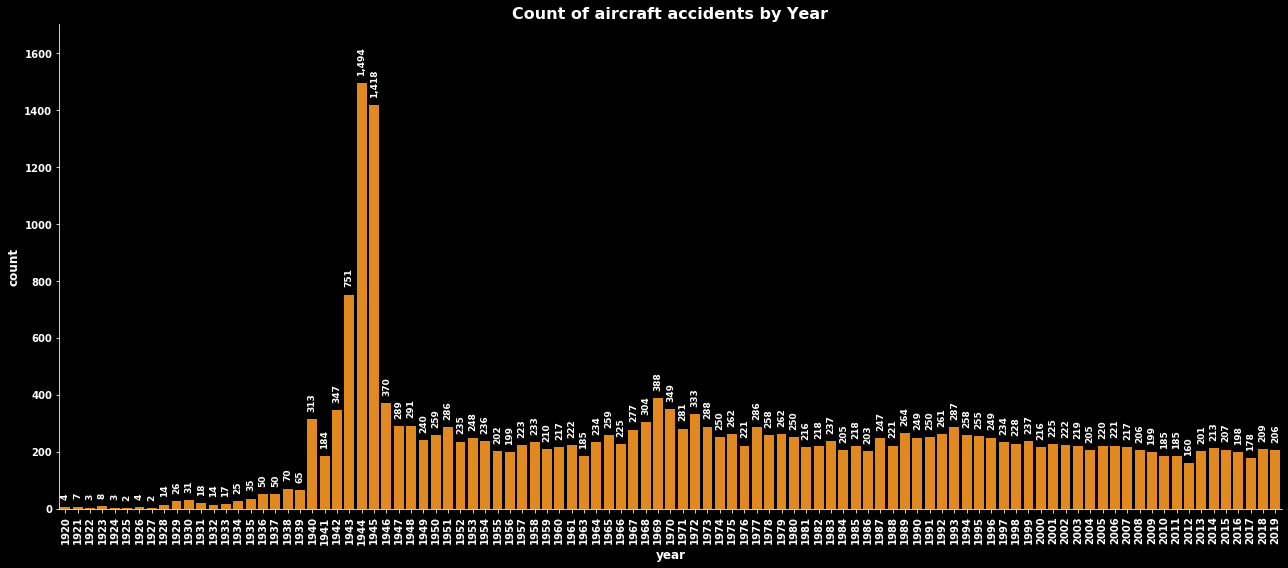

In [79]:
plot_countplot(
    df, 
    'year', 
    hue_column=None, 
    figsize=(18, 8), 
    title='Count of aircraft accidents by Year',
    ylims=(0, 1700)
)

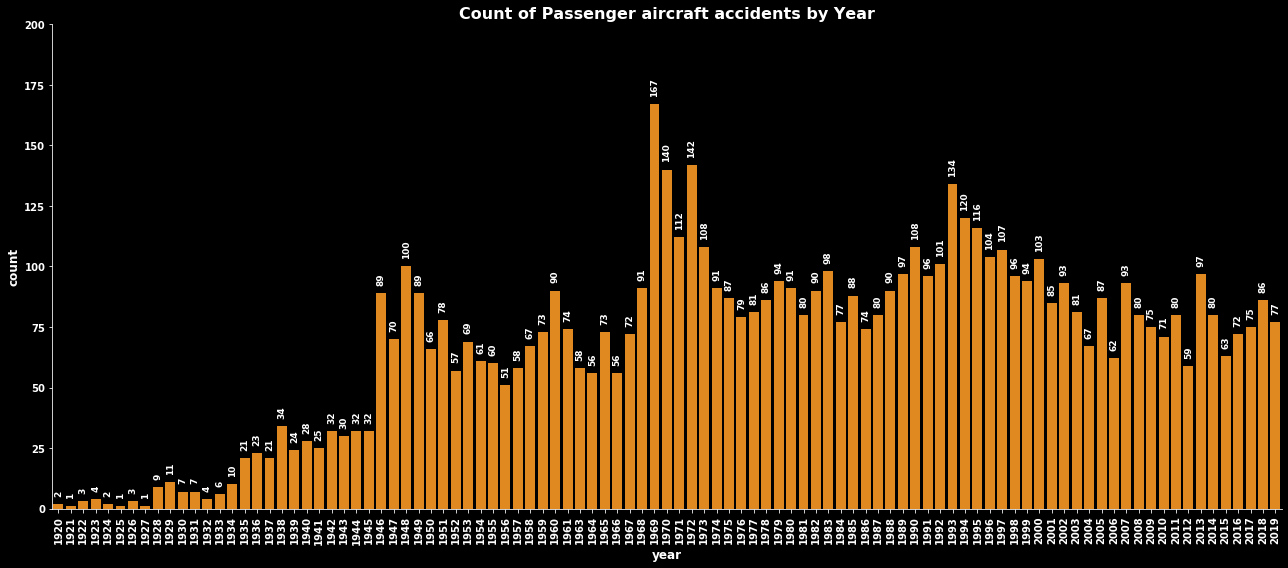

In [80]:
plot_countplot(
    df[df['nature_group'] == 'Passenger'], 
    'year', 
    figsize=(18, 8), 
    title='Count of Passenger aircraft accidents by Year',
    ylims=(0, 200)
)

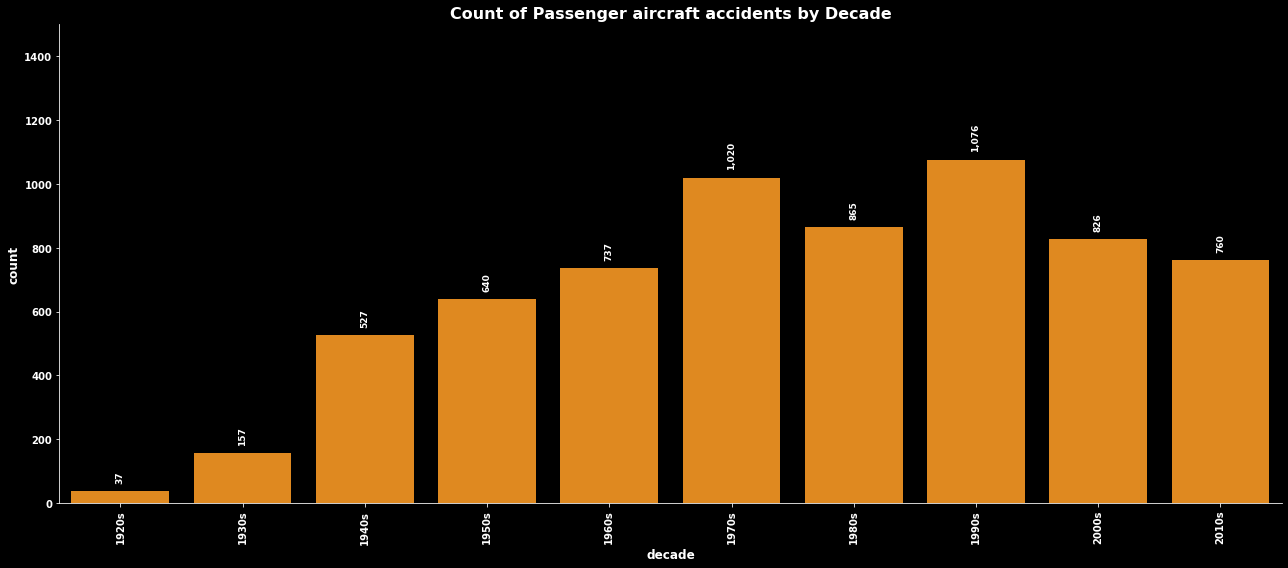

In [83]:
plot_countplot(
    df[df['nature_group'] == 'Passenger'], 
    'decade', 
    figsize=(18, 8), 
    title='Count of Passenger aircraft accidents by Decade',
    ylims=(0, 1500)
)

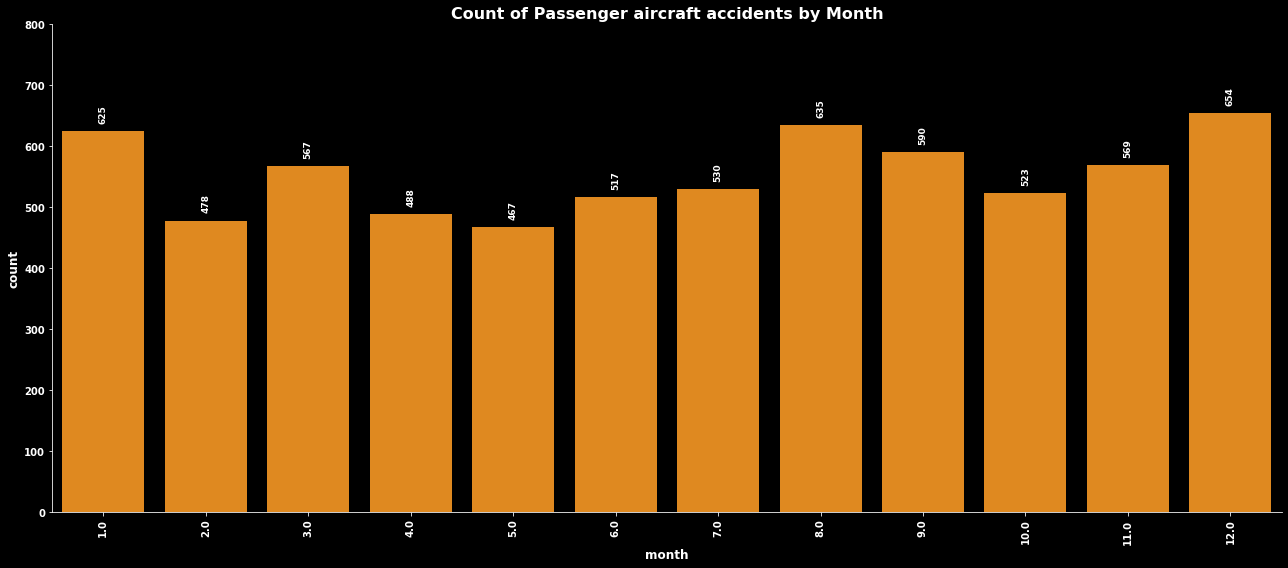

In [85]:
plot_countplot(
    df[df['nature_group'] == 'Passenger'], 
    'month', 
    figsize=(18, 8), 
    title='Count of Passenger aircraft accidents by Month',
    ylims=(0, 800)
)

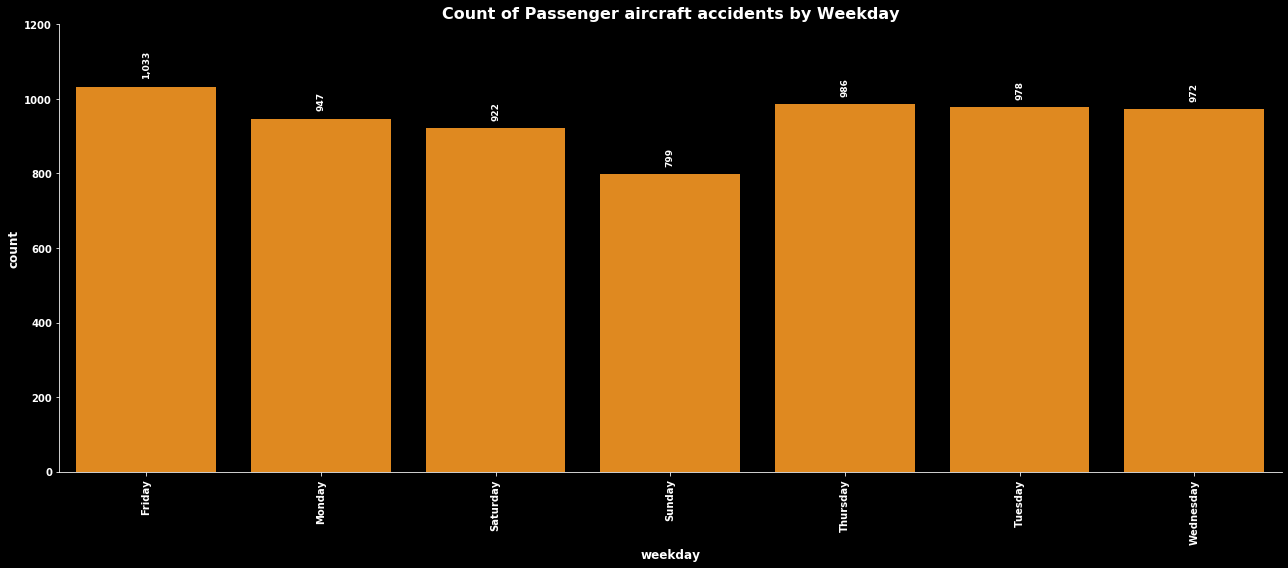

In [86]:
plot_countplot(
    df[df['nature_group'] == 'Passenger'], 
    'weekday', 
    figsize=(18, 8), 
    title='Count of Passenger aircraft accidents by Weekday',
    ylims=(0, 1200)
)

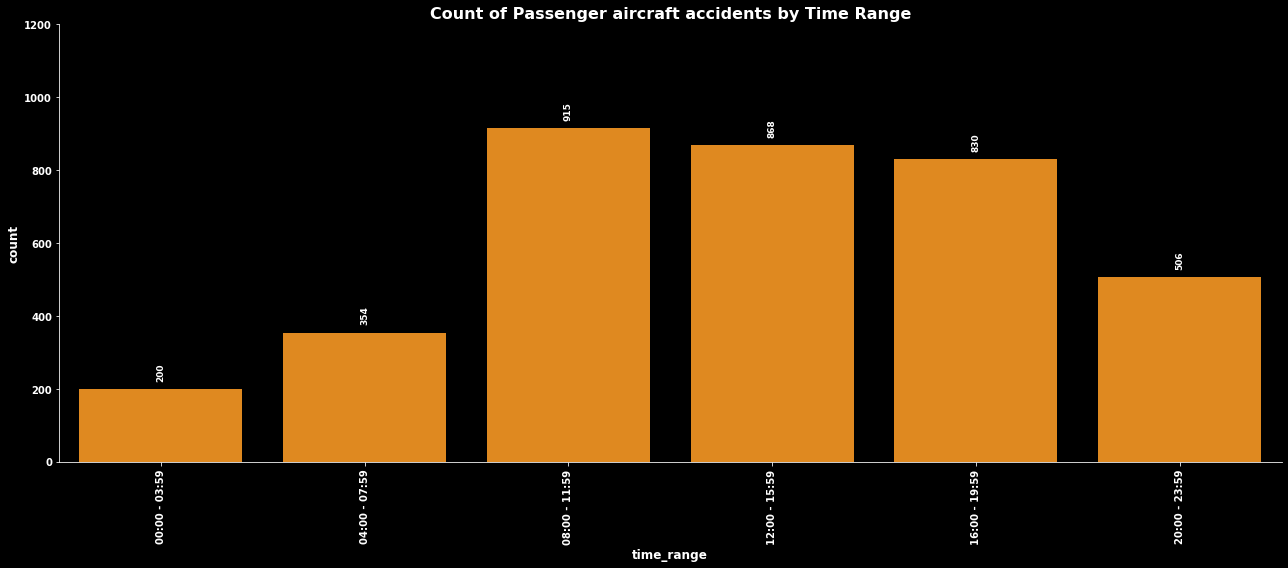

In [88]:
plot_countplot(
    df[df['nature_group'] == 'Passenger'], 
    'time_range', 
    figsize=(18, 8), 
    title='Count of Passenger aircraft accidents by Time Range',
    ylims=(0, 1200)
)

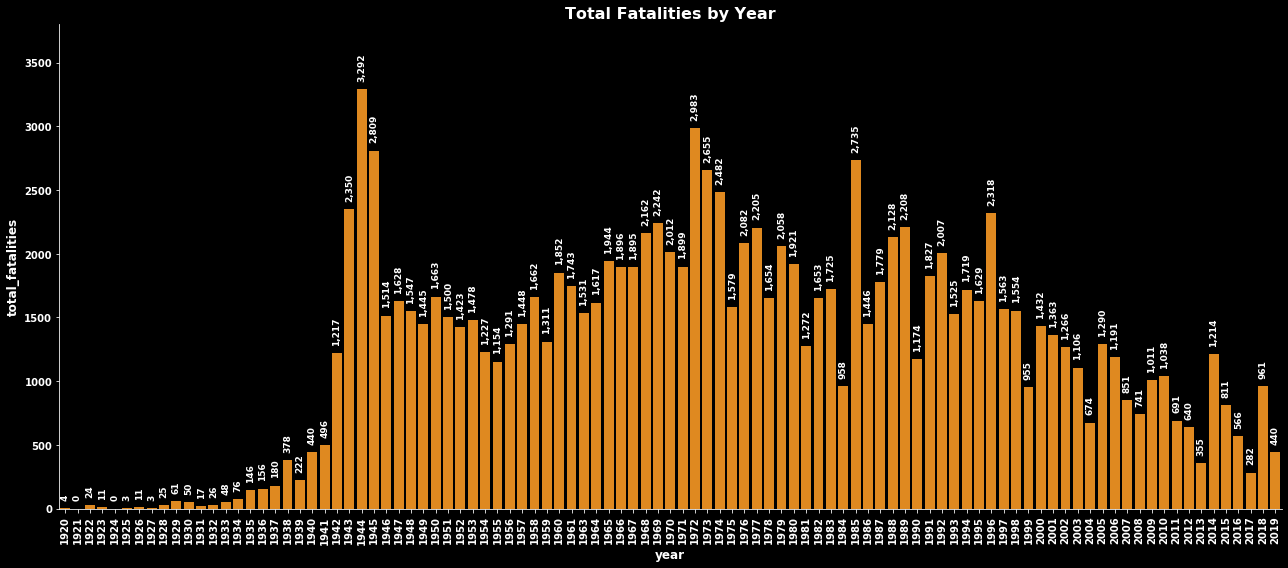

In [89]:
plot_aggregated_barplot(
    df,
    'year',
    'total_fatalities',
    'sum',
    figsize=(18, 8),
    title='Total Fatalities by Year',
    ylims=(0, 3800)
)

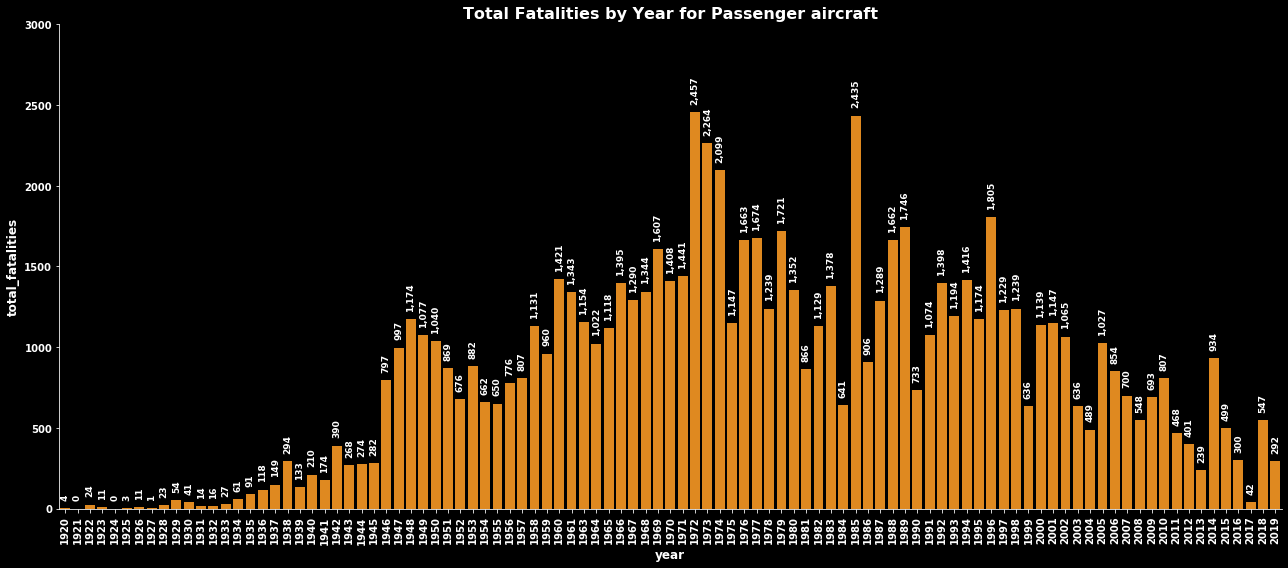

In [58]:
plot_aggregated_barplot(
    df[df['nature_group'] == 'Passenger'],
    'year',
    'total_fatalities',
    'sum',
    figsize=(18, 8),
    title='Total Fatalities by Year for Passenger aircraft',
    ylims=(0, 3000)
)

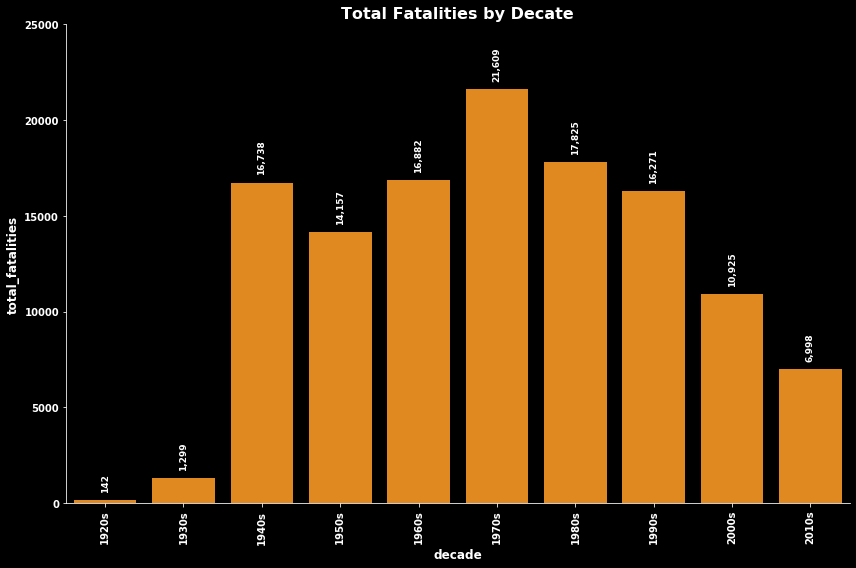

In [61]:
plot_aggregated_barplot(
    df,
    'decade',
    'total_fatalities',
    'sum',
    figsize=(12, 8),
    title='Total Fatalities by Decate',
    ylims=(0, 25000)
)

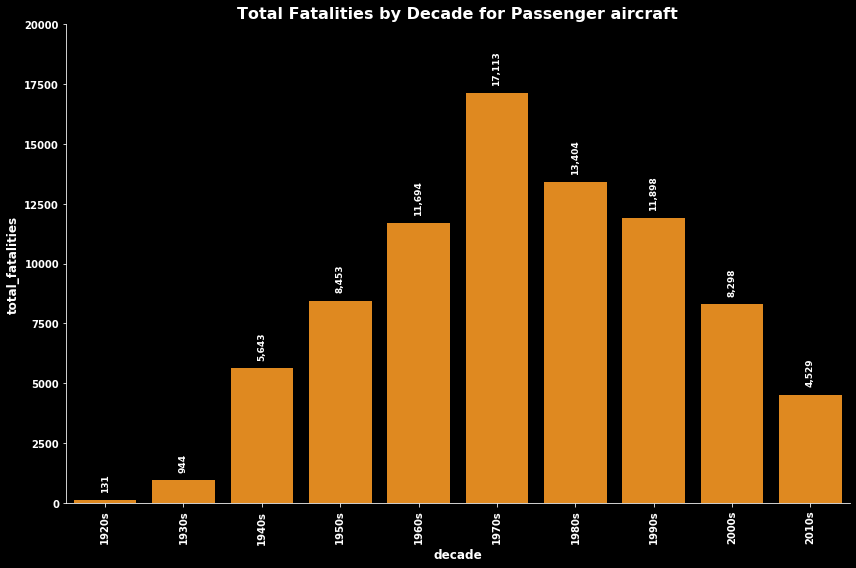

In [63]:
plot_aggregated_barplot(
    df[df['nature_group'] == 'Passenger'],
    'decade',
    'total_fatalities',
    'sum',
    figsize=(12, 8),
    title='Total Fatalities by Decade for Passenger aircraft',
    ylims=(0, 20000)
)

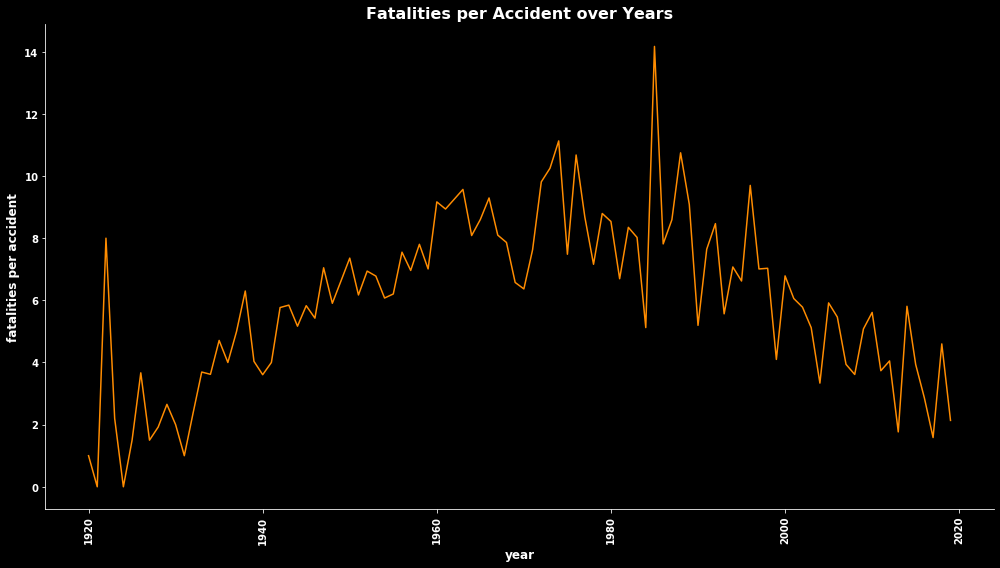

In [68]:
temp = df[pd.notna(df['total_fatalities'])].groupby('year').agg({'total_fatalities': ('sum', 'count')})
temp.columns = ['_'.join(col).strip() for col in temp.columns]
temp = temp.reset_index()
temp['fatalities per accident'] = temp['total_fatalities_sum'] / temp['total_fatalities_count']
plot_lineplot(
    temp,
    'year',
    'fatalities per accident',
    title='Fatalities per Accident over Years'
)

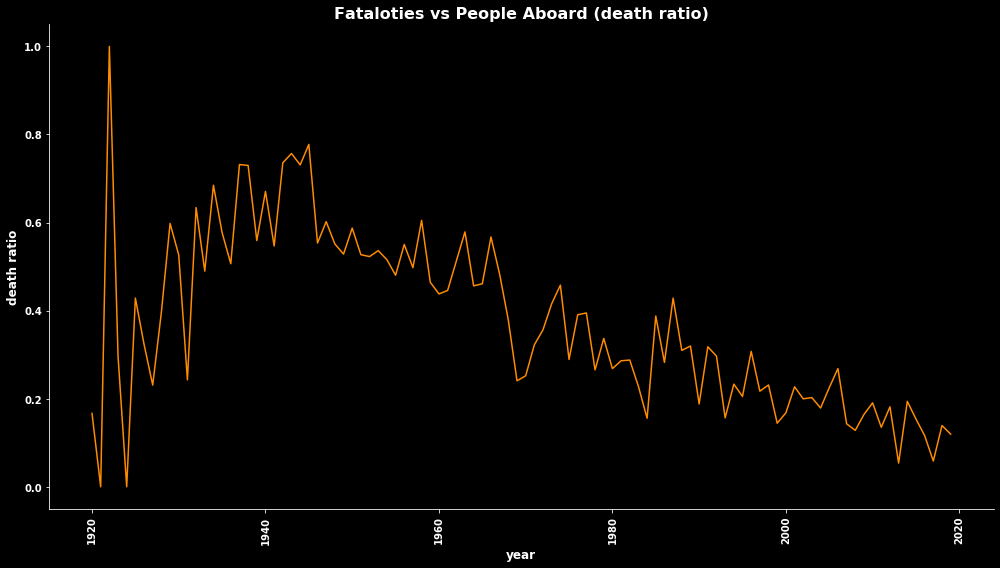

In [94]:
temp = df[pd.notna(df['total_fatalities'])].groupby('year').agg({'total_fatalities': 'sum', 'total_occupants': 'sum'})
temp = temp.reset_index()
temp['death ratio'] = temp['total_fatalities'] / temp['total_occupants']
plot_lineplot(
    temp,
    'year',
    'death ratio',
    title='Fataloties vs People Aboard (death ratio)'
)